# Series Registration

In [1]:
import numpy as np
import torch
import cv2
import kornia as K
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple

from utils import convert_image_to_tensor, convert_img_tensor_to_numpy, match_sizes_resize, match_sizes_resize_batch, invert_list
# from masking import keypoints_roi_to_image, scale_image, mask_leaf, erode_crop_leaf, crop_ROI_erode_leaf, 
from masking import fetch_full_leaf, fetch_rotated_ROI, fetch_unrotated_ROI, fetch_image_mask_pair
from registration import fetch_registered_image_mask_pair
from loftr import loftr_match, tps_skimage, register_loftr_tps, warp_tps, compose_tps
from plotting import plot_image_pair, plot_overlay, plot_matches, plot_matches_conf, plot_match_coverage
from DatasetTools.LeafImageSeries import LeafDataset

In [2]:
leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    # leaf_uid="ESWW0070020_1",
    leaf_uid="ESWW0070023_6", # has much missing data 
    load=('roi_leaf_masks'),
    # load=('target_images', 'target_masks', 'leaf_masks', 'seg_masks', 'det_masks', 'cropped_images', 'rois', 'images', 'keypoints', 'roi_leaf_masks'),
    verbose=True
)

Initializing dataset...
Getting Series...
Getting paths...


Extracting IDs...
Removing duplicate IDs...
Filtering by leaf_uid...
Compiling list...
Loading requested values...
Loading images...


Exception ignored in: <_io.BufferedReader name='../leaf-image-sequences/raw/2023/20230607/20230607_162518_ESWW0070023_6.JPG'>
Traceback (most recent call last):
  File "/home/renku/work/LeafAlignment/DatasetTools/LeafImageSeries.py", line -1, in _load_requested
OSError: [Errno 107] Transport endpoint is not connected
Exception ignored in: <_io.BufferedReader name='../leaf-image-sequences/raw/2023/20230606/20230606_122818_ESWW0070023_6.JPG'>
Traceback (most recent call last):
  File "/home/renku/work/LeafAlignment/DatasetTools/LeafImageSeries.py", line -1, in _load_requested
OSError: [Errno 107] Transport endpoint is not connected
Exception ignored in: <_io.BufferedReader name='../leaf-image-sequences/raw/2023/20230606/20230606_095135_ESWW0070023_6.JPG'>
Traceback (most recent call last):
  File "/home/renku/work/LeafAlignment/DatasetTools/LeafImageSeries.py", line -1, in _load_requested
OSError: [Errno 107] Transport endpoint is not connected
Exception ignored in: <_io.BufferedReader n

OSError: [Errno 107] Transport endpoint is not connected

## Problem Cases

In [2]:
moving_ind = 13

leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    leaf_uid="ESWW0070020_2", 
    load=('roi_leaf_masks'),
    verbose=False
)

Processing series: 100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


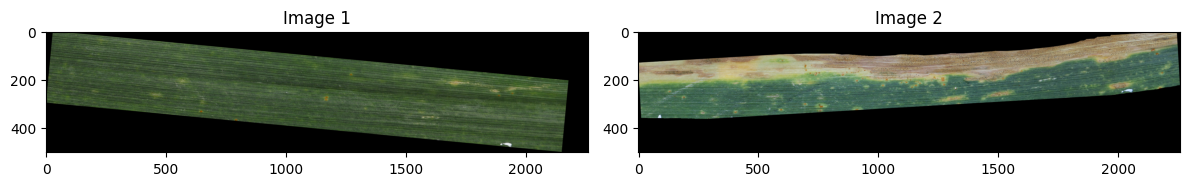

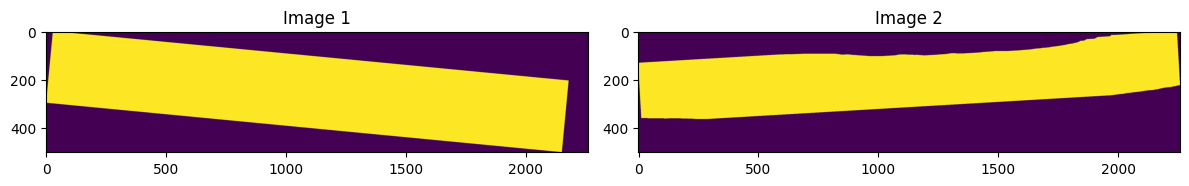

In [ ]:
img_fixed, mask_fixed = fetch_image_mask_pair(leaf, 0, img_scale="roi", erase_markers=True, pre_rotate=False)
img_moving, mask_moving = fetch_image_mask_pair(leaf, moving_ind, img_scale="roi", erase_markers=True, pre_rotate=False)
img_fixed, img_moving, mask_fixed, mask_moving = match_sizes_resize(img_fixed, img_moving, mask_fixed, mask_moving)
_ = plot_image_pair(img_fixed, img_moving)
_ = plot_image_pair(mask_fixed, mask_moving)

Total matches: 648
Matches with Confidence > 0.5: 253
Inliers: 307 (47.38%)
Threshold set to 0.5
Estimating TPS transform...
Transforming moving image...
Transforming moving image...


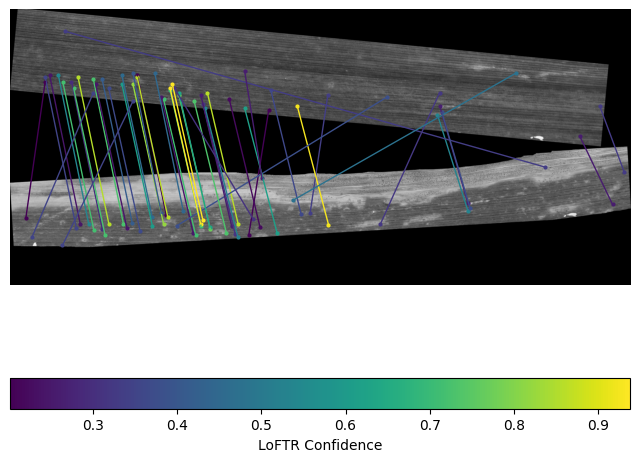

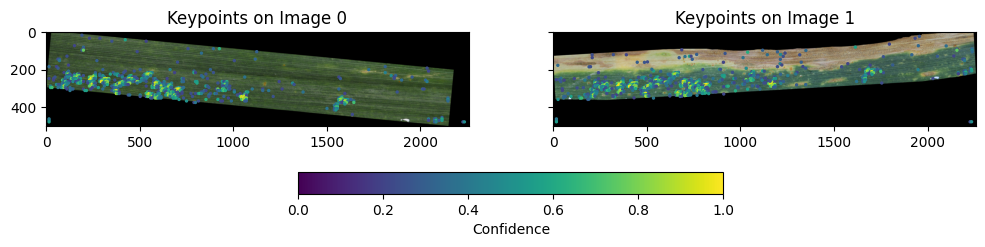

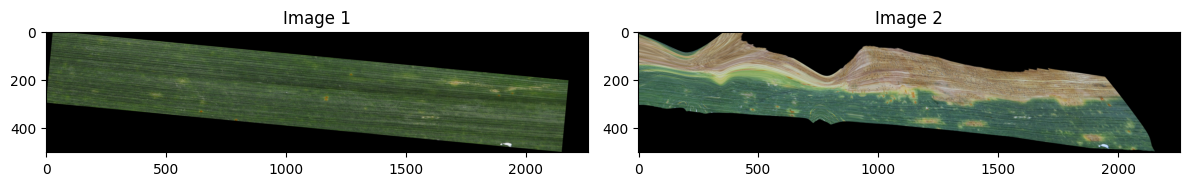

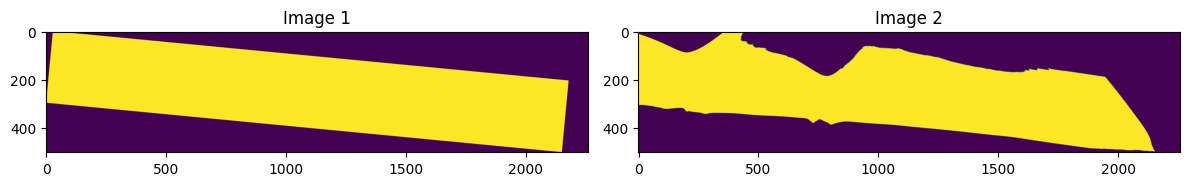

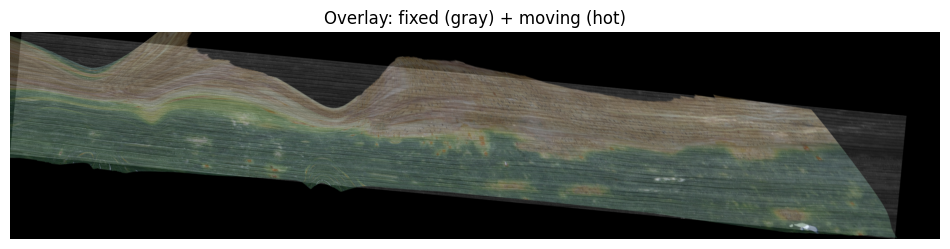

In [13]:
warped_moving_img, warped_moving_mask = register_loftr_tps(img_fixed, img_moving, mask_moving=mask_moving, threshold=0.5, verbose=True, plot_loftr_matches=True, return_tps=False)
_ = plot_image_pair(img_fixed, warped_moving_img)
_ = plot_image_pair(mask_fixed, warped_moving_mask)
_ = plot_overlay(img_fixed, warped_moving_img)

Total matches: 648
Matches with Confidence > 0.5: 253
Inliers: 307 (47.38%)
Threshold set to 0.3
Estimating TPS transform...
Transforming moving image...
Transforming moving image...


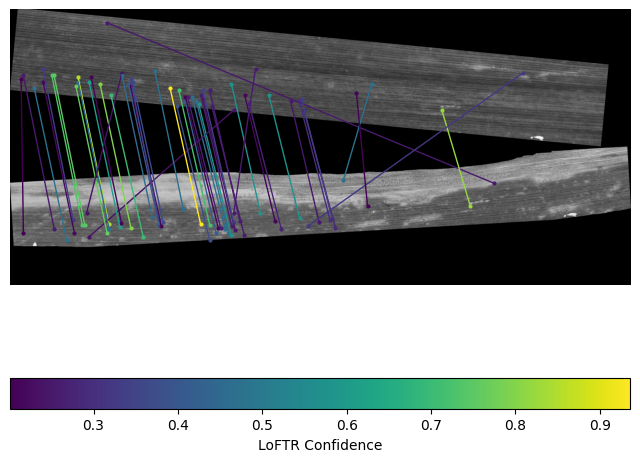

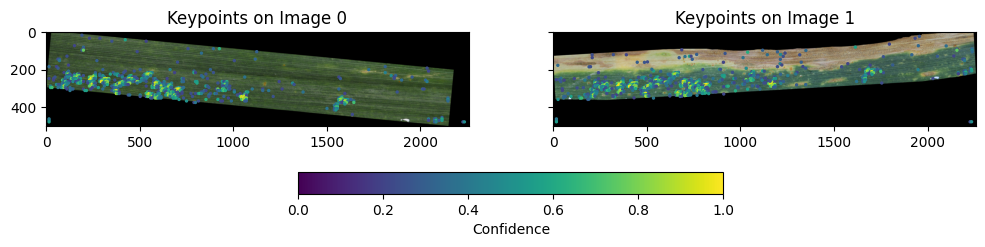

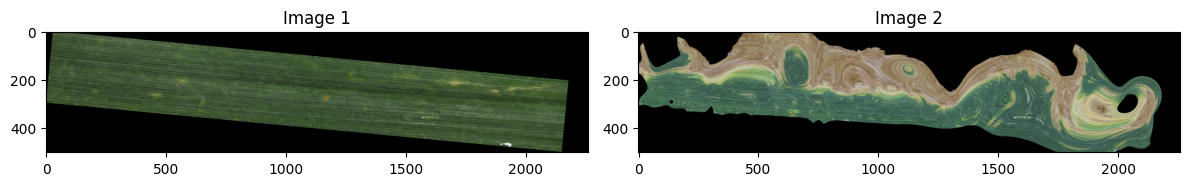

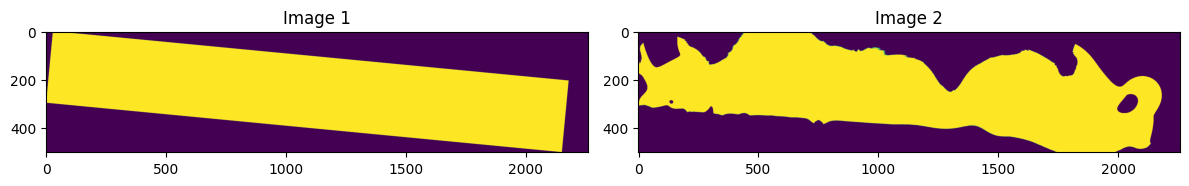

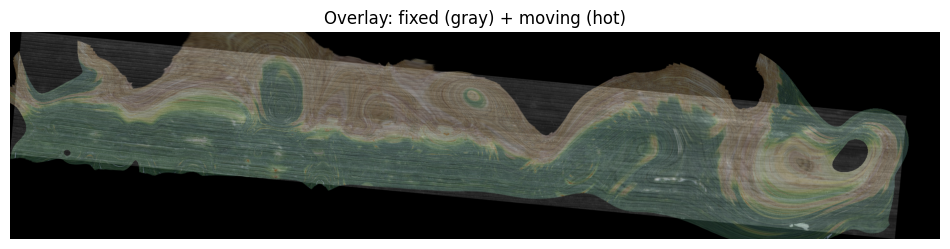

In [54]:
# lower base threshold
warped_moving_img, warped_moving_mask = register_loftr_tps(img_fixed, img_moving, mask_moving=mask_moving, threshold=0.3, verbose=True, plot_loftr_matches=True, return_tps=False)
_ = plot_image_pair(img_fixed, warped_moving_img)
_ = plot_image_pair(mask_fixed, warped_moving_mask)
_ = plot_overlay(img_fixed, warped_moving_img)

=> lowering threshold is a bad idea

## Individual

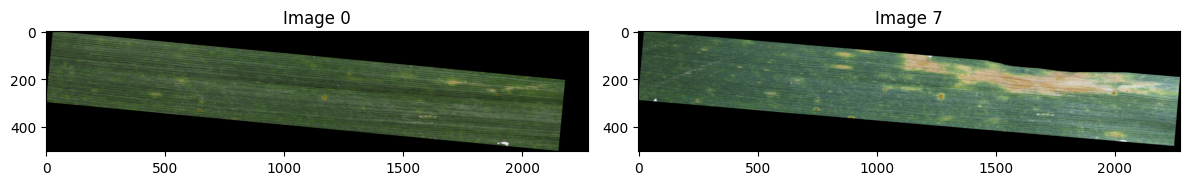

In [3]:
i = 7
img_fixed_og, mask_fixed_og = fetch_image_mask_pair(leaf, 0, img_scale="roi")
img_moving_og, mask_moving_og = fetch_image_mask_pair(leaf, i, img_scale="roi")
img_fixed, img_moving, mask_fixed, mask_moving = match_sizes_resize(img_fixed_og, img_moving_og, mask_fixed_og, mask_moving_og)
_ = plot_image_pair(img_fixed, img_moving, 0 ,i)

In [ ]:
def register_leaf_seq(leaf: LeafDataset, img_scale: str="full", pre_rotate: bool=False, erase_markers: bool=True, return_masks: bool=True, use_scaling_erosion: bool=False, verbose: bool=False):
    # img_fixed_og, mask_fixed_og = fetch_image_mask_pair(leaf, 0, img_scale=img_scale, pre_rotate=pre_rotate, erase_markers=erase_markers, use_scaling_erosion=use_scaling_erosion)

    # retrieve images
    if verbose:
        print("Fetching leaves...")
    imgs = []
    if return_masks:
        masks = []

    for ind in range(leaf.n_leaves):
        img, mask = img_moving, mask_moving = fetch_image_mask_pair(leaf, ind, img_scale=img_scale, pre_rotate=pre_rotate, erase_markers=erase_markers, use_scaling_erosion=use_scaling_erosion)
        imgs.append(img)
        if return_masks:
            masks.append(mask)

    # resize
    imgs, masks = match_sizes_resize_batch(imgs, masks)
    
    registered_imgs = [imgs[0]]
    if return_masks:
        registered_masks = [masks[0]]
    
    moving_indices = np.arange(1, leaf.n_leaves)
    for ind in tqdm(moving_indices):
        # img_moving, mask_moving = fetch_image_mask_pair(leaf, ind, img_scale=img_scale, pre_rotate=pre_rotate, erase_markers=erase_markers, use_scaling_erosion=use_scaling_erosion)

        # resize
        # img_fixed, img_moving, mask_fixed, mask_moving = match_sizes_resize(img_fixed_og, img_moving, mask_fixed_og, mask_moving)

        # register
        img_moving, mask_moving = register_loftr_tps(imgs[0], imgs[ind], mask_moving=masks[ind], verbose=verbose, plot_loftr_matches=False, return_tps=False)

        registered_imgs.append(img_moving)
        if return_masks:
            registered_masks.append(mask_moving)

    if return_masks:
        return registered_imgs, registered_masks
    else:
        return registered_imgs

In [ ]:
imgs, masks = register_leaf_seq(leaf, img_scale="roi")
# imgs

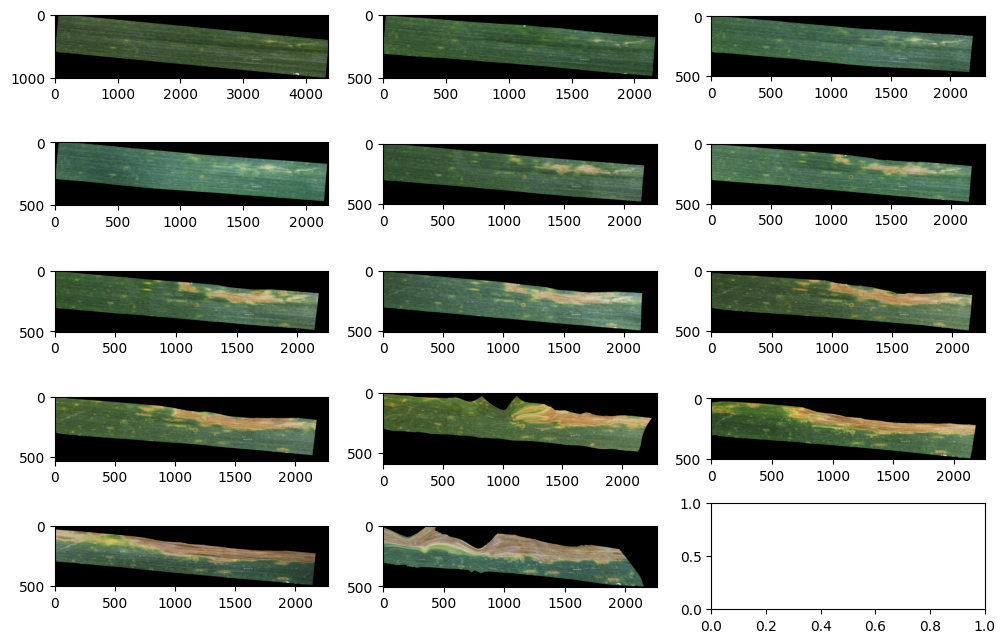

In [19]:
fig, axs = plt.subplots(5, 3, figsize=(12,8))
axs[0,0].imshow(K.tensor_to_image(imgs[0]))
axs[0,1].imshow(K.tensor_to_image(imgs[1]))
axs[0,2].imshow(K.tensor_to_image(imgs[2]))

axs[1,0].imshow(K.tensor_to_image(imgs[3]))
axs[1,1].imshow(K.tensor_to_image(imgs[4]))
axs[1,2].imshow(K.tensor_to_image(imgs[5]))

axs[2,0].imshow(K.tensor_to_image(imgs[6]))
axs[2,1].imshow(K.tensor_to_image(imgs[7]))
axs[2,2].imshow(K.tensor_to_image(imgs[8]))

axs[3,0].imshow(K.tensor_to_image(imgs[9]))
axs[3,1].imshow(K.tensor_to_image(imgs[10]))
axs[3,2].imshow(K.tensor_to_image(imgs[11]))

axs[4,0].imshow(K.tensor_to_image(imgs[12]))
axs[4,1].imshow(K.tensor_to_image(imgs[13]))
# axs[4,2].imshow(K.tensor_to_image(imgs[14]))
plt.show()

## Purely Sequential

### Batch Size Matching

In [15]:
i0 = 0
i1 = 4
i2 = 7
img0, mask0 = fetch_image_mask_pair(leaf, i0, img_scale="roi", erase_markers=True, pre_rotate=False)
img1, mask1 = fetch_image_mask_pair(leaf, i1, img_scale="roi", erase_markers=True, pre_rotate=False)
img2, mask2 = fetch_image_mask_pair(leaf, i2, img_scale="roi", erase_markers=True, pre_rotate=False)

imgs = [img0, img1, img2]
masks = [mask0, mask1, mask2]

Error: missing data for leaf ESWW0070023_6 at index 4


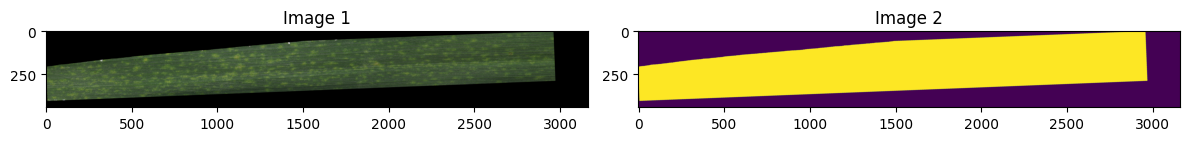

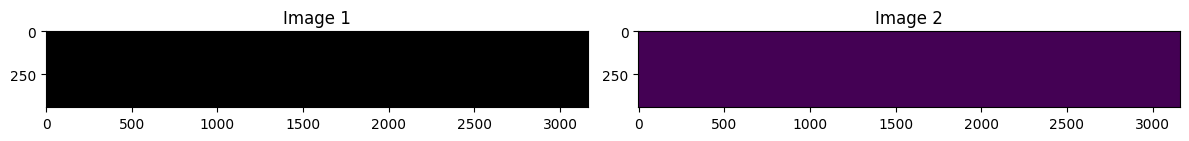

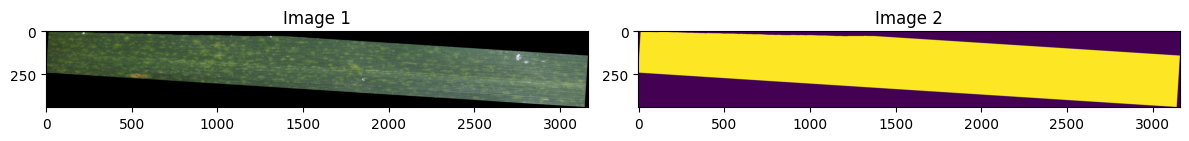

In [26]:
padded_imgs, padded_masks = match_sizes_resize_batch(imgs, masks)
for i in range(len(padded_imgs)):
    if padded_imgs[i] is None:
        _ = plot_image_pair(torch.zeros_like(padded_imgs[0]), torch.zeros_like(padded_masks[0]))
        continue
    _ = plot_image_pair(padded_imgs[i], padded_masks[i])


### Composing TPS Transforms

In [136]:
# register
img1_w, mask1_w, tps_01 = register_loftr_tps(imgs[0], imgs[1], mask_moving=masks[1], verbose=True, plot_loftr_matches=False, return_tps=True)
img2_w, mask2_w, tps_12 = register_loftr_tps(imgs[1], imgs[2], mask_moving=masks[2], verbose=True, plot_loftr_matches=False, return_tps=True)
 

Total matches: 5127
Matches with Confidence > 0.5: 3495
Inliers: 3043 (59.35%)
Setting threshold..
Threshold set to 0.9725122093056
Estimating TPS transform...
Transforming moving image...
Transforming moving image...
Total matches: 6687
Matches with Confidence > 0.5: 4791
Inliers: 3298 (49.32%)
Setting threshold..
Threshold set to 0.9887410009315738
Estimating TPS transform...
Transforming moving image...
Transforming moving image...


In [3]:
def compose_tps(transforms):
    def composed(coords):
        for t in transforms:
            coords = t(coords)
        return coords
    return composed

In [131]:
# order matters!
# [T_k_to_k-1, ..., T_1_to_0]
tps_chain = [tps_12, tps_01]
coord_map = compose_tps(tps_chain)

Transforming moving image...


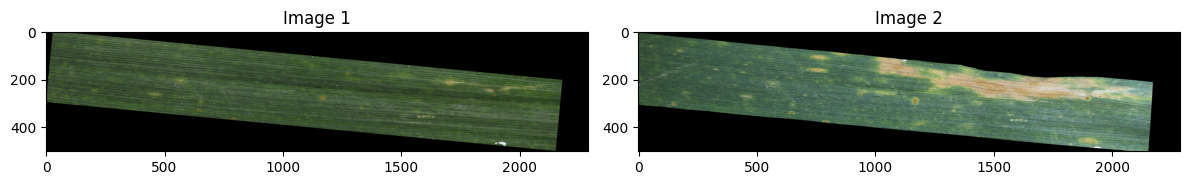

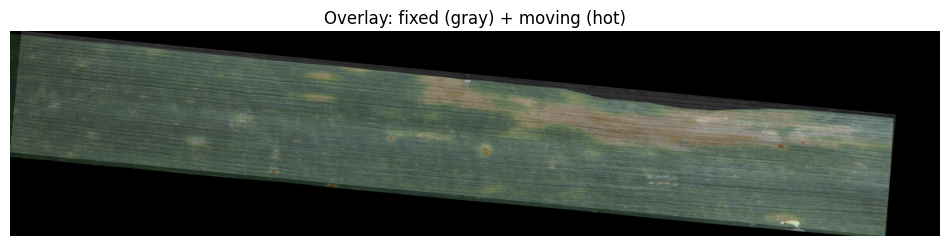

In [137]:
out = warp_tps(imgs[2], coord_map, verbose=True)
_ = plot_image_pair(imgs[0], out)
_ = plot_overlay(imgs[0], out)

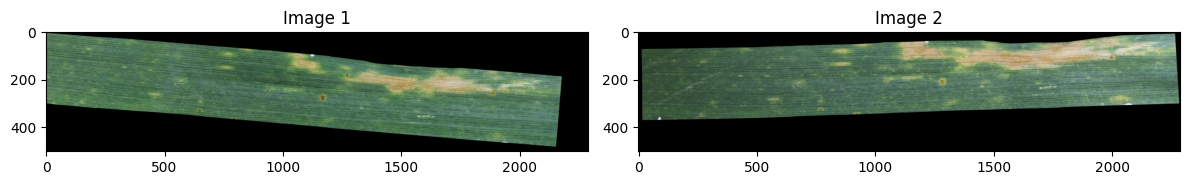

In [ ]:
_ = plot_image_pair(img1_w, img2_w)

### Composing Transforms more efficiently

In [11]:
rows, cols = imgs[2].shape[2:] # assuming img is a tensor
img = K.tensor_to_image(imgs[2])
rows, cols = img.shape[:2]
# rr, cc = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
# coords = np.column_stack([rr.ravel(), cc.ravel()])

rr, cc = np.meshgrid(
    np.arange(rows),
    np.arange(cols),
    indexing='ij'
)

coords = np.stack([rr, cc], axis=-1)   # shape (rows, cols, 2)
coords_flat = coords.reshape(-1, 2)
print(coords.shape)
print(coords_flat.shape)

(503, 2286, 2)
(1149858, 2)


In [ ]:
# for t in tps_chain:
#     coords = t(coords)
coords_flat_out = coords_flat
for t in tps_chain:
    coords_flat_out = t(coords_flat_out)


In [30]:
# print(coords.shape)
# coords = coords.reshape(rows, cols, 2)
# print(coords.shape)

print(coords_flat_out.shape)
coords_out = coords_flat_out.reshape(rows, cols, 2)
print(coords_out.shape)

(1149858, 2)
(503, 2286, 2)


In [35]:
print(coords_out.shape)
print(img.shape)
coords_out.shape == (img.shape[0], img.shape[1], 2)


(503, 2286, 2)
(503, 2286, 3)


True

In [10]:
from skimage.transform import warp as warp_ski

out = warp_ski(
    img,
    inverse_map=coords_out,
    order=3,
    mode='reflect',
    preserve_range=True
)
# out = warp_tps(imgs[2], coords, verbose=True)
_ = plot_image_pair(imgs[0], out)
_ = plot_overlay(imgs[0], out)


NameError: name 'img' is not defined

In [13]:
rows, cols = img.shape[:2]

rr, cc = np.meshgrid(
    np.arange(rows),
    np.arange(cols),
    indexing='ij'
)

coords = np.stack([rr, cc], axis=-1)
coords_flat = coords.reshape(-1, 2)

coords_out = coords_flat
for t in tps_chain:
    coords_out = t(coords_out)

coords_out = coords_out.reshape(rows, cols, 2)
coords_for_warp = np.transpose(coords_out, (2, 0, 1))

warped = warp_ski(
    img,
    coords_for_warp,
    order=3,
    mode='reflect',
    preserve_range=True
)


RuntimeError: invalid shape for coordinate array

### List Inversion

In [68]:
l = [None, '01', '12', '23', '34', '45', '56', '67', '78', '89', None, None, None]
i = 4
j = 1
print(l[i], l[j])
n = len(l)
l.reverse()
print(l)
print(l[n-i-1:-j])
# print(l[1:3+1].reverse())

34 01
[None, None, None, '89', '78', '67', '56', '45', '34', '23', '12', '01', None]
['34', '23', '12', '01']


In [122]:
l = [None, '01', '12', '23', '34', '45', '56', '67', '78', '89', None, None, None]
print(l)
invert_list(l, -1, 0)

[None, '01', '12', '23', '34', '45', '56', '67', '78', '89', None, None, None]


[None, None, None, '89', '78', '67', '56', '45', '34', '23', '12', '01', None]

In [4]:
def invert_list(l: list, last_ind: int, first_ind: int=1):
    """
    Given a list [a, b, c, d, e, f, ...], (locally) inverts the list and returns the list slice of [first_ind, ..., last_ind] 
    of the *non-inverted* list. 

    E.g. for first_ind=1 and last_ind=4, returns [e, d, c, b]

    If last_ind=-1, all elements after (and including) first_ind are used. This is equivalent to using last_ind=len(l)-1

    """
    n = len(l)
    if last_ind == -1:
        last_ind = n-1
    l_copy = list(reversed(l)) # to avoid altering the original list, make a local copy
    if first_ind == 0:
        return l_copy[n-1-last_ind:]
    else: 
        return l_copy[n-1-last_ind: -first_ind]
    # l.reverse()
    # return l[n-1-last_ind: -first_ind]

### All together

In [ ]:
def register_leaf_seq_sequential(leaf: LeafDataset, img_scale: str="full", pre_rotate: bool=False, erase_markers: bool=True, return_masks: bool=True, use_scaling_erosion: bool=False):
    
    # retrieve images
    imgs = []
    if return_masks:
        masks = []

    for ind in range(leaf.n_leaves):
        img, mask = img_moving, mask_moving = fetch_image_mask_pair(leaf, ind, img_scale=img_scale, pre_rotate=pre_rotate, erase_markers=erase_markers, use_scaling_erosion=use_scaling_erosion)
        imgs.append(img)
        if return_masks:
            masks.append(mask)

    # resize
    imgs, masks = match_sizes_resize_batch(imgs, masks)
    
    tps = [None]*leaf.n_leaves
    # registered_imgs = [imgs[0]]*leaf.n_leaves
    registered_imgs = [imgs[0]]
    if return_masks:
        registered_masks = [masks[0]]
    moving_indices = np.arange(1, leaf.n_leaves)
    for ind in tqdm(moving_indices):

        # mkpts0, mkpts1, confidence, _, n_matches = loftr_match(img_fixed, img_moving, verbose=verbose, return_n_matches=True)
        
        # if n_matches['conf_matches'] > 3:
        #     tps = tps_skimage(mkpts0, mkpts1, confidence, threshold, img_moving, warp_moving=False, verbose=verbose)
        # else:
        #     print("No enough matches for TPS found")
        #     tps = None
        
        # get TPS transform from current image to previous
        tps[ind] = register_loftr_tps(imgs[ind-1], imgs[ind], threshold=0.5, verbose=False, plot_loftr_matches=False, warp_moving=False, return_tps=True)
        
        # if ind > 1:
        #     tps_chain = [tps[ind], tps[ind-1]]
        #     coord_map = compose_tps(tps_chain)
        # else:
        #     coord_map = tps[ind]

        # TODO: what if None?
        tps_chain = invert_list(tps, ind) # get inverted list of tps transforms
        coord_map = compose_tps(tps_chain)

        # warp images
        registered_imgs.append( warp_tps(imgs[ind], coord_map, verbose=True) )
        if return_masks:
            registered_masks.append( warp_tps(masks[ind], coord_map, verbose=False) )

    if return_masks:
        return registered_imgs, registered_masks
    else:
        return registered_imgs

In [9]:
imgs, masks = register_leaf_seq_sequential(leaf, img_scale="roi")

  0%|          | 0/14 [00:00<?, ?it/s]

Total matches: 8241
Matches with Confidence > 0.5: 6490
Inliers: 1609 (19.52%)
Setting threshold..
Threshold set to 0.9927942405962072
Estimating TPS transform...
Transforming moving image...


  7%|▋         | 1/14 [00:53<11:35, 53.50s/it]

Total matches: 9009
Matches with Confidence > 0.5: 7474
Inliers: 3186 (35.36%)
Setting threshold..
Threshold set to 0.9976388167585652
Estimating TPS transform...
Transforming moving image...


 14%|█▍        | 2/14 [02:52<18:27, 92.27s/it]

Total matches: 7485
Matches with Confidence > 0.5: 5577
Inliers: 1515 (20.24%)
Setting threshold..
Threshold set to 0.9909928007452591
Estimating TPS transform...
Transforming moving image...


 21%|██▏       | 3/14 [06:01<25:00, 136.37s/it]

Total matches: 6872
Matches with Confidence > 0.5: 4878
Inliers: 2359 (34.33%)
Setting threshold..
Threshold set to 0.982407813955584
Estimating TPS transform...
Transforming moving image...


 29%|██▊       | 4/14 [10:14<30:24, 182.43s/it]

Total matches: 8904
Matches with Confidence > 0.5: 7042
Inliers: 1795 (20.16%)
Setting threshold..
Threshold set to 0.9963106511852582
Estimating TPS transform...
Transforming moving image...


 36%|███▌      | 5/14 [15:29<34:29, 229.98s/it]

Total matches: 8614
Matches with Confidence > 0.5: 6511
Inliers: 1769 (20.54%)
Setting threshold..
Threshold set to 0.9927942405962072
Estimating TPS transform...
Transforming moving image...


 43%|████▎     | 6/14 [21:51<37:34, 281.83s/it]

Total matches: 8925
Matches with Confidence > 0.5: 7158
Inliers: 1731 (19.39%)
Setting threshold..
Threshold set to 0.9970485209482065
Estimating TPS transform...
Transforming moving image...


 50%|█████     | 7/14 [29:20<39:15, 336.44s/it]

Total matches: 9168
Matches with Confidence > 0.5: 7725
Inliers: 3073 (33.52%)
Setting threshold..
Threshold set to 0.9992262874754466
Estimating TPS transform...
Transforming moving image...


 57%|█████▋    | 8/14 [37:53<39:15, 392.64s/it]

Total matches: 9253
Matches with Confidence > 0.5: 7590
Inliers: 5254 (56.78%)
Setting threshold..
Threshold set to 0.9981110534068522
Estimating TPS transform...
Transforming moving image...


 64%|██████▍   | 9/14 [47:30<37:30, 450.18s/it]

Total matches: 8881
Matches with Confidence > 0.5: 7456
Inliers: 2793 (31.45%)
Setting threshold..
Threshold set to 0.9992262874754466
Estimating TPS transform...
Transforming moving image...


 71%|███████▏  | 10/14 [58:21<34:09, 512.39s/it]

Total matches: 7367
Matches with Confidence > 0.5: 5888
Inliers: 1497 (20.32%)
Setting threshold..
Threshold set to 0.9976388167585652
Estimating TPS transform...
Transforming moving image...


 79%|███████▊  | 11/14 [1:10:15<28:41, 573.92s/it]

Total matches: 5330
Matches with Confidence > 0.5: 3707
Inliers: 1090 (20.45%)
Setting threshold..
Threshold set to 0.97800976744448
Estimating TPS transform...
Transforming moving image...


 86%|████████▌ | 12/14 [1:22:57<21:02, 631.13s/it]

Total matches: 4971
Matches with Confidence > 0.5: 3305
Inliers: 1001 (20.14%)
Setting threshold..
Threshold set to 0.9725122093056
Estimating TPS transform...
Transforming moving image...


 86%|████████▌ | 12/14 [1:24:15<14:02, 421.27s/it]


KeyboardInterrupt: 

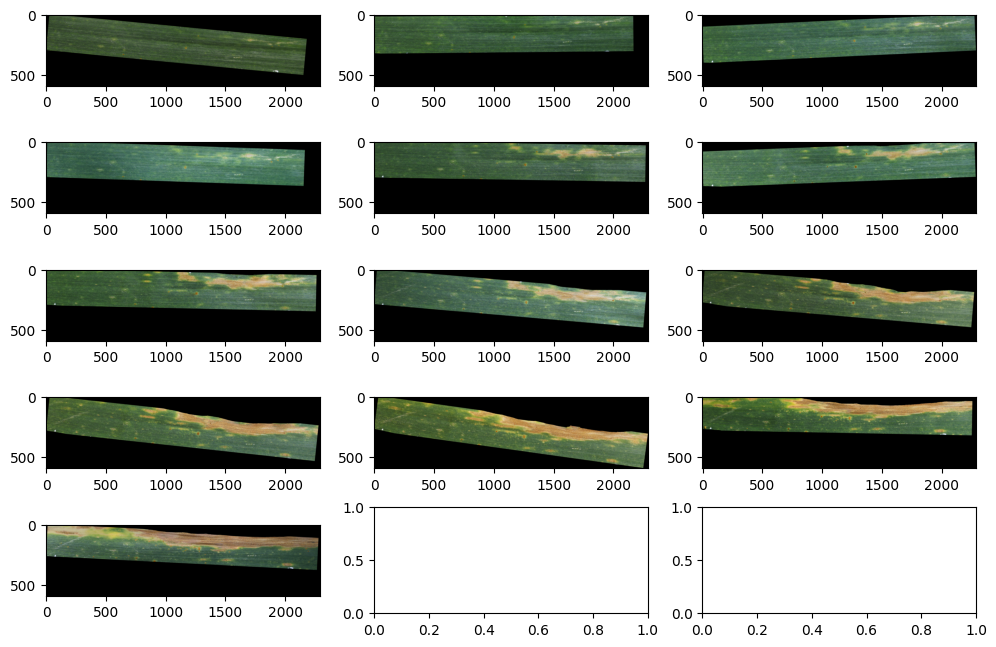

In [10]:
fig, axs = plt.subplots(5, 3, figsize=(12,8))
axs[0,0].imshow(K.tensor_to_image(imgs[0]))
axs[0,1].imshow(K.tensor_to_image(imgs[1]))
axs[0,2].imshow(K.tensor_to_image(imgs[2]))

axs[1,0].imshow(K.tensor_to_image(imgs[3]))
axs[1,1].imshow(K.tensor_to_image(imgs[4]))
axs[1,2].imshow(K.tensor_to_image(imgs[5]))

axs[2,0].imshow(K.tensor_to_image(imgs[6]))
axs[2,1].imshow(K.tensor_to_image(imgs[7]))
axs[2,2].imshow(K.tensor_to_image(imgs[8]))

axs[3,0].imshow(K.tensor_to_image(imgs[9]))
axs[3,1].imshow(K.tensor_to_image(imgs[10]))
axs[3,2].imshow(K.tensor_to_image(imgs[11]))

axs[4,0].imshow(K.tensor_to_image(imgs[12]))
# axs[4,1].imshow(K.tensor_to_image(imgs[13]))
# axs[4,2].imshow(K.tensor_to_image(imgs[14]))
plt.show()

## Skipping Connections

In [ ]:
ind = 2
anchors = [0]#, 4, 7]
l = [None, "01", "12", "23", "34", "45", "56", "67", "78", "89"]
l = [None, "01", "02", "03", "04", "45", "46", "47", "78", "79"]
out = [l[i] for i in anchors + [ind]] # goal: 04 47 79
print(out)
invert_list(out, ind)

[None, '02']


[]

In [40]:
def stop_condition(confidence, conf_threshold: float=0.5, n_threshold=400):
    # if we have more than 200 confident matches, return True
    out =  (torch.sum(confidence > conf_threshold) > n_threshold)
    # print(f"condition: {out}")
    return out

In [ ]:
def register_leaf_seq_semi_sequential(leaf: LeafDataset, condition=stop_condition, img_scale: str="full", pre_rotate: bool=False, erase_markers: bool=True, return_masks: bool=True, use_scaling_erosion: bool=False, verbose=False):
    
    # retrieve images
    imgs = []
    if return_masks:
        masks = []

    if verbose:
        print("Fechting images...")
    for ind in range(leaf.n_leaves):
        img, mask = img_moving, mask_moving = fetch_image_mask_pair(leaf, ind, img_scale=img_scale, pre_rotate=pre_rotate, erase_markers=erase_markers, use_scaling_erosion=use_scaling_erosion)
        imgs.append(img)
        if return_masks:
            masks.append(mask)

    # resize
    imgs, masks = match_sizes_resize_batch(imgs, masks)
    
    tps = [None]*leaf.n_leaves
    registered_imgs = [imgs[0]]
    if return_masks:
        registered_masks = [masks[0]]
    moving_indices = np.arange(1, leaf.n_leaves)
    anchor = [0]
    threshold = 0.5
    sanity = [None]*leaf.n_leaves

    for ind in tqdm(moving_indices):

        if imgs[ind] is None:
            print(f"No image data for index {ind}")
            registered_imgs.append(None)
            if return_masks:
                registered_masks.append(None)
            continue

        mkpts0, mkpts1, confidence, _, n_matches = loftr_match(imgs[anchor[-1]], imgs[ind], verbose=verbose, return_n_matches=True)
        # warped_moving_img, warped_moving_mask, tps[ind] = register_loftr_tps(imgs[ind-1], imgs[ind], threshold=0.5, verbose=False, plot_loftr_matches=False, warp_moving=True, return_tps=True)
        
        if condition(confidence, conf_threshold=0.8):
            # if condition is satisfied, warp moving image

            _, tps[ind] = tps_skimage(mkpts0, mkpts1, confidence, threshold, imgs[ind], warp_moving=False, verbose=verbose)
            
        else:
            # make sure we don't link back to an empty picture
            j = ind-1
            while imgs[j] is None:
                j -= 1
            anchor.append(j)
            mkpts0, mkpts1, confidence, _, n_matches = loftr_match(imgs[anchor[-1]], imgs[ind], verbose=verbose, return_n_matches=True)
            
            _, tps[ind] = tps_skimage(mkpts0, mkpts1, confidence, threshold, imgs[ind], warp_moving=False, verbose=verbose)


        # sanity check
        # print(f"----- Index {ind} -----------")
        # sanity[ind] = f"{anchor[-1]}-{ind}"
        # relevant_sanity = [sanity[i] for i in anchor + [ind]]
        # sanity_chain = invert_list(relevant_sanity, -1)
        # print(f" anchors: {anchor}")
        # print(f"full chain: {sanity}")
        # print(f"sliced chain: {relevant_sanity}")
        # print(f"inverted chain: {sanity_chain}")

        
        relevant_tps = [tps[i] for i in anchor + [ind]] # pick out transforms for relevant steps
        tps_chain = invert_list(relevant_tps, -1) # invert the list
        # coord_map = compose_tps(tps_chain) # compose the transforms
        # print(len(tps_chain))
        if len(tps_chain) > 1:
            coord_map = compose_tps(tps_chain) # compose the transforms
        else:
           coord_map = tps_chain[0]
        

        # warp images
        registered_imgs.append( warp_tps(imgs[ind], coord_map, verbose=verbose) )
        if return_masks:
            registered_masks.append( warp_tps(masks[ind], coord_map, verbose=verbose) )

    
    if return_masks:
        return registered_imgs, registered_masks
    else:
        return registered_imgs

In [39]:
imgs, masks = register_leaf_seq_semi_sequential(leaf, img_scale="roi", verbose=False)

Error: missing data for leaf ESWW0070023_6 at index 4


  0%|          | 0/14 [00:00<?, ?it/s]

condition: True


  7%|▋         | 1/14 [00:27<06:01, 27.81s/it]

condition: True


 14%|█▍        | 2/14 [00:54<05:23, 26.97s/it]

condition: True


 21%|██▏       | 3/14 [01:23<05:10, 28.19s/it]

No image data for index 4
condition: True


 36%|███▌      | 5/14 [01:55<03:11, 21.26s/it]

condition: True


 43%|████▎     | 6/14 [02:35<03:31, 26.48s/it]

condition: True


 50%|█████     | 7/14 [03:06<03:16, 28.05s/it]

condition: True


 57%|█████▋    | 8/14 [03:38<02:53, 28.97s/it]

condition: True


 64%|██████▍   | 9/14 [04:10<02:29, 29.93s/it]

condition: True


 71%|███████▏  | 10/14 [04:40<01:59, 29.87s/it]

condition: True


 79%|███████▊  | 11/14 [05:08<01:27, 29.31s/it]

condition: False


 86%|████████▌ | 12/14 [06:17<01:22, 41.16s/it]

condition: True


 93%|█████████▎| 13/14 [07:24<00:49, 49.04s/it]

condition: True


100%|██████████| 14/14 [08:32<00:00, 36.61s/it]


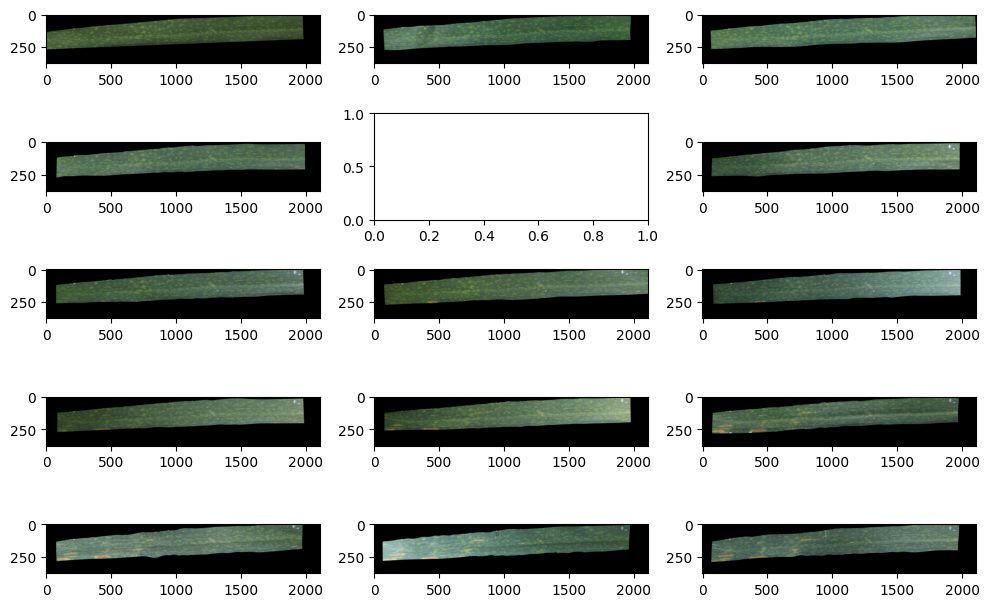

In [ ]:
fig, axs = plt.subplots(5, 3, figsize=(12,8))
axs[0,0].imshow(K.tensor_to_image(imgs[0]))
axs[0,1].imshow(K.tensor_to_image(imgs[1]))
axs[0,2].imshow(K.tensor_to_image(imgs[2]))

axs[1,0].imshow(K.tensor_to_image(imgs[3]))
# axs[1,1].imshow(K.tensor_to_image(imgs[4]))
axs[1,2].imshow(K.tensor_to_image(imgs[5]))

axs[2,0].imshow(K.tensor_to_image(imgs[6]))
axs[2,1].imshow(K.tensor_to_image(imgs[7]))
axs[2,2].imshow(K.tensor_to_image(imgs[8]))

axs[3,0].imshow(K.tensor_to_image(imgs[9]))
axs[3,1].imshow(K.tensor_to_image(imgs[10]))
axs[3,2].imshow(K.tensor_to_image(imgs[11]))

axs[4,0].imshow(K.tensor_to_image(imgs[12]))
axs[4,1].imshow(K.tensor_to_image(imgs[13]))
axs[4,2].imshow(K.tensor_to_image(imgs[14]))
plt.show()

## All-In-One Function

In [ ]:
def fetch_registered_image_mask_seq(leaf, registration_method, leaf_style, plot_masked_images=False, plot_loftr_matches=False):
    """
    for the given index pair, fetches registered fixed and moving image plus matching masks.

    Args:
        leaf: leaf sequence to retrieve data from
        fixed_img_ind: index of the fixed image
        moving_img_ind: index of the moving image
        method: registration to utilize
            "Piecewise Affine": Jonas' pre-existing method
            "LoFTR + TPS Full": TPS based on LoFTR matches on full leaf
            "LoFTR + TPS Full with Markers": TPS based on LoFTR matches on full leaf, without eroding away markers
            "LoFTR + TPS ROI": TPS based on LoFTR matches only on ROI
            "LoFTR + TPS ROI with Markers": TPS based on LoFTR matches only on ROI, without eroding away markers
            "LoFTR + TPS ROI Pre-Rotated": TPS based on LoFTR matches only on ROI, where ROI is already rotated  to align with the image borders
            "LoFTR + TPS ROI Pre-Rotated with Markers": TPS based on LoFTR matches only on pre-rotated ROI, without eroding away markers
        plot_masked_images: if True, displays images & masks after masking, before registration
        plot_loftr_matches: if True, displays diagnostic images of matches detected by LoFTR

    Returns:
        List of registered images
        List of corresponding registered masks

    """
    if registration_method == "Piecewise Affine":
        imgs, masks = fetch_preregistered_leaf_seq(leaf)
        return imgs, masks
        
    else:
        
        if leaf_style == "LoFTR + TPS ROI":
            leaf_kwargs = {"img_scale": "roi", "erase_markers": True, "pre_rotate": False}
        elif leaf_style == "LoFTR + TPS ROI with Markers":
            leaf_kwargs = {"img_scale": "roi", "erase_markers": False, "pre_rotate": False}
        elif leaf_style == "LoFTR + TPS ROI Pre-Rotated":
            leaf_kwargs = {"img_scale": "roi", "erase_markers": True, "pre_rotate": True}
        elif leaf_style == "LoFTR + TPS ROI Pre-Rotated with Markers":
            leaf_kwargs = {"img_scale": "roi", "erase_markers": False, "pre_rotate": True}
        elif leaf_style == "LoFTR + TPS Full":
            leaf_kwargs = {"img_scale": "false", "erase_markers": True}
        elif leaf_style == "LoFTR + TPS Full with Markers":
            leaf_kwargs = {"img_scale": "false", "erase_markers": False}
        else:
            raise ValueError(f'Unknown leaf style {leaf_style}')

        # register
        if registration_method == "LoFTR + TPS Individual":
            imgs, masks = register_leaf_seq(leaf, **leaf_kwargs)
        elif registration_method == "LoFTR + TPS Semi-Sequential":
            imgs, masks = register_leaf_seq_semi_sequential(leaf, **leaf_kwargs)
        else:
            raise ValueError(f'Unknown registration method {registration_method}')
        
        return imgs, masks
